In [192]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from dotenv import load_dotenv
from census import Census
from itertools import chain
from matplotlib import pyplot as plt
import contextily as cx

In [193]:
load_dotenv()
api_key = os.getenv("api_key")

# Load Census Data

In [194]:
# load relationship files
df_tract_rel = pd.read_csv(
    "https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt",
    sep="|",
)
df_block_rel = pd.read_csv("tab2010_tab2020_st36_ny.txt")

In [195]:
# nyc_tracts = gpd.read_file(
#     "https://data.cityofnewyork.us/resource/63ge-mke6.geojson?$limit=100000"
# )
nyc_tracts = gpd.read_file("2020 Census Tracts_20250307.geojson")
nyc_tracts.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,geometry
0,1843004.52241,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),10833.0439286,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,1006116.58429,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5075.33199978,Manhattan,001401,MN0302,1,None,36061001401,1001401,MN03,14.01,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ..."
2,1226206.24719,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4459.1560187,Manhattan,001402,MN0302,1,None,36061001402,1001402,MN03,14.02,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ..."
3,2399276.86435,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),6391.92117449,Manhattan,001800,MN0302,1,None,36061001800,1001800,MN03,18,"MULTIPOLYGON (((-73.98985 40.72052, -73.98972 ..."
4,1740173.87581,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5779.06260724,Manhattan,002201,MN0302,1,None,36061002201,1002201,MN03,22.01,"MULTIPOLYGON (((-73.97875 40.71993, -73.97879 ..."


In [196]:
# load 2010 tracts
nyc_tracts_2010 = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_36061_tract10.zip"
)
nyc_tracts_2010.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,061,027100,36061027100,271,Census Tract 271,G5020,S,192555,0,+40.8519392,-073.9342905,"POLYGON ((-73.93666 40.85045, -73.93634 40.851..."
1,36,061,012900,36061012900,129,Census Tract 129,G5020,S,404996,407508,+40.7650139,-073.9998117,"POLYGON ((-74.00827 40.76485, -74.00585 40.768..."
2,36,061,014401,36061014401,144.01,Census Tract 144.01,G5020,S,74319,0,+40.7752486,-073.9475520,"POLYGON ((-73.94937 40.77688, -73.94919 40.776..."
3,36,061,009900,36061009900,99,Census Tract 99,G5020,S,1007102,1125670,+40.7523775,-074.0083669,"POLYGON ((-73.99843 40.75556, -73.99866 40.755..."
4,36,061,014601,36061014601,146.01,Census Tract 146.01,G5020,S,74328,0,+40.7771918,-073.9521610,"POLYGON ((-73.94987 40.7762, -73.95034 40.7755..."


In [197]:
# select all tracts in the east village
cb3_sectors = {
    2020: {
        1: ["004200", "004002", "004001", "003602", "003800"],
        2: ["003400", "003200", "003002"],
        3: ["002800", "002602", "002601", "002202"],
        4: ["003001", "002201"],
        5: ["001200", "001001", "001402", "001401"],
        6: ["000600", "000201", "000202"],
        7: ["000800", "002700", "002500"],
        8: ["002902", "001600"],
        9: ["001800", "003601"],
        10: ["002400", "002000", "001002"],
    },
    2010: {
        1: ["004200", "004000", "003602", "003800"],
        2: ["003400", "003200", "003002"],
        3: ["002800", "002602", "002601", "002202"],
        4: ["003001", "002201"],
        5: ["001200", "001001", "001402", "001401"],
        6: ["000600", "000201", "000202"],
        7: ["000800", "002700", "002500"],
        8: ["002900", "001600"],
        9: ["001800", "003601"],
        10: ["002400", "002000", "001002"],
    },
}

cb3_tracts = list(chain.from_iterable(cb3_sectors[2020].values()))

In [198]:
# subset rel file to CB3
df_tract_rel["GEOID_form_20"] = (
    df_tract_rel["GEOID_TRACT_20"].astype(str).str.pad(11, side="left", fillchar="0")
)
df_tract_rel["GEOID_form_10"] = (
    df_tract_rel["GEOID_TRACT_10"].astype(str).str.pad(11, side="left", fillchar="0")
)
cb3_tract_rel = df_tract_rel[
    (df_tract_rel["GEOID_form_20"].str.slice(-6).isin(cb3_tracts))
    & (df_tract_rel["GEOID_form_20"].str.slice(0, 5) == "36061")
]
cb3_tracts_2010 = cb3_tract_rel["GEOID_form_10"].str.slice(5).unique()

cb3_tracts_by_year = {2020: cb3_tracts, 2010: cb3_tracts_2010}

In [199]:
# check tracts that changed
cb3_tract_rel[cb3_tract_rel["GEOID_TRACT_20"] != cb3_tract_rel["GEOID_TRACT_10"]]

,OID_TRACT_20,GEOID_TRACT_20,NAMELSAD_TRACT_20,AREALAND_TRACT_20,AREAWATER_TRACT_20,MTFCC_TRACT_20,FUNCSTAT_TRACT_20,OID_TRACT_10,GEOID_TRACT_10,NAMELSAD_TRACT_10,AREALAND_TRACT_10,AREAWATER_TRACT_10,MTFCC_TRACT_10,FUNCSTAT_TRACT_10,AREALAND_PART,AREAWATER_PART,GEOID_form_20,GEOID_form_10
77768,2079015681794567,36061002902,Census Tract 29.02,123830,0,G5020,S,20740460864031,36061002900,Census Tract 29,273358,0,G5020,S,123830,0,36061002902,36061002900
77780,2079019627440616,36061004001,Census Tract 40.01,91742,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,91742,0,36061004001,36061004000
77781,2079015681794515,36061004002,Census Tract 40.02,86591,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,86591,0,36061004002,36061004000


In [200]:
# create a gdf of just cb3
cb3_gdf = nyc_tracts[nyc_tracts["cdta2020"] == "MN03"].copy()
print(cb3_gdf.shape[0], len(cb3_tracts))

31 31


In [201]:
# create a gdf of just cb3 for 2010
nyc_tracts_2010["ct2010"] = nyc_tracts_2010["GEOID10"].str.slice(5)
cb3_gdf_2010 = nyc_tracts_2010[nyc_tracts_2010["ct2010"].isin(cb3_tracts_by_year[2010])]
print(cb3_gdf_2010.shape[0], len(cb3_tracts_by_year[2010]))

30 30


In [202]:
cb3_gdf["sectors"] = np.select(
    [cb3_gdf["ct2020"].isin(cb3_sectors[2020][i]) for i in cb3_sectors[2020].keys()],
    list(cb3_sectors[2020].keys()),
)
cb3_gdf.head()

cb3_gdf_2010["sectors"] = np.select(
    [
        cb3_gdf_2010["ct2010"].isin(cb3_sectors[2010][i])
        for i in cb3_sectors[2010].keys()
    ],
    list(cb3_sectors[2010].keys()),
)
cb3_gdf_2010.head()

/opt/anaconda3/envs/cb3-census/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,ct2010,sectors
10,36,061,001401,36061001401,14.01,Census Tract 14.01,G5020,S,93510,0,+40.7151603,-073.9873314,"POLYGON ((-73.98608 40.7144, -73.98716 40.7143...",001401,5
34,36,061,000201,36061000201,2.01,Census Tract 2.01,G5020,S,90205,88971,+40.7098991,-073.9855836,"POLYGON ((-73.98455 40.7095, -73.98404 40.7048...",000201,6
83,36,061,002500,36061002500,25,Census Tract 25,G5020,S,133767,107616,+40.7085998,-073.9978104,"POLYGON ((-73.996 40.7089, -73.99365 40.7047, ...",002500,7
88,36,061,002202,36061002202,22.02,Census Tract 22.02,G5020,S,56090,0,+40.7212601,-073.9811422,"POLYGON ((-73.97875 40.71993, -73.97973 40.720...",002202,3
98,36,061,003400,36061003400,34,Census Tract 34,G5020,S,160257,0,+40.7290092,-073.9814618,"POLYGON ((-73.978 40.72943, -73.97854 40.72875...",003400,2


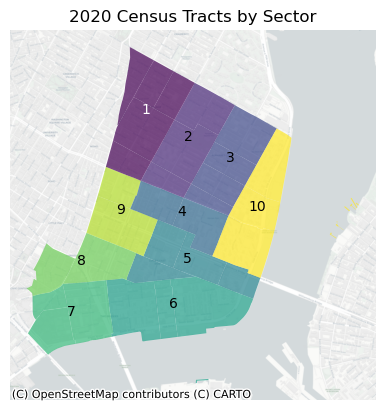

In [203]:
# create sector map
cb3_gdf = cb3_gdf.to_crs(2263)
cb3_gdf_diss = cb3_gdf.dissolve(by="sectors").to_crs(2263).reset_index()
cb3_gdf_diss["coords"] = cb3_gdf_diss["geometry"].centroid.apply(lambda x: x.coords[0])
ax = cb3_gdf.plot(column="sectors", alpha=0.7)
for idx, row in cb3_gdf_diss.iterrows():
    color = "black"
    if row["sectors"] == 1:
        color = "white"
    plt.annotate(
        text=row["sectors"], xy=row["coords"], horizontalalignment="center", color=color
    )
cx.add_basemap(ax, zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron)
plt.title("2020 Census Tracts by Sector")
ax.set_axis_off();

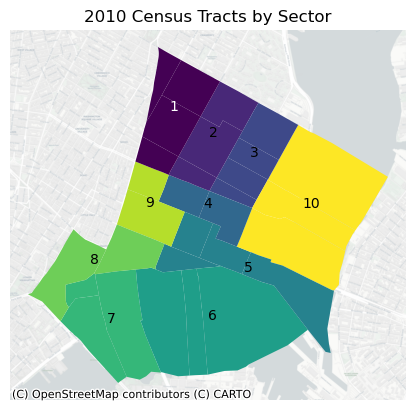

In [204]:
# create sector map
cb3_gdf_2010 = cb3_gdf_2010.to_crs(2263)
cb3_gdf_2010_diss = cb3_gdf_2010.dissolve(by="sectors").reset_index()
cb3_gdf_2010_diss["coords"] = cb3_gdf_2010_diss["geometry"].centroid.apply(
    lambda x: x.coords[0]
)
ax = cb3_gdf_2010.plot(column="sectors")
for idx, row in cb3_gdf_2010_diss.iterrows():
    color = "black"
    if row["sectors"] == 1:
        color = "white"
    plt.annotate(
        text=row["sectors"], xy=row["coords"], horizontalalignment="center", color=color
    )
cx.add_basemap(ax, zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron)
plt.title("2010 Census Tracts by Sector")
ax.set_axis_off();

## Load Census Data

In [205]:
census = Census(api_key)

In [206]:
# dec columns
dec_dict = {
    2020: {
        "P1_001N": "total",
        "P2_002N": "hispanic_latino",
        "P2_005N": "nh_white",
        "P2_006N": "nh_black",
        "P2_007N": "nh_aian",
        "P2_008N": "nh_asian",
        "P2_009N": "nh_nhpi",
        "P2_010N": "nh_other",
        "P2_011N": "nh_multi",
    },
    2010: {
        "P001001": "total",
        "P002002": "hispanic_latino",
        "P002005": "nh_white",
        "P002006": "nh_black",
        "P002007": "nh_aian",
        "P002008": "nh_asian",
        "P002009": "nh_nhpi",
        "P002010": "nh_other",
        "P002011": "nh_multi",
    },
    2000: {
        "PL001001": "total",
        "PL002002": "hispanic_latino",
        "PL002005": "nh_white",
        "PL002006": "nh_black",
        "PL002007": "nh_aian",
        "PL002008": "nh_asian",
        "PL002009": "nh_nhpi",
        "PL002010": "nh_other",
        "PL002011": "nh_multi",
    },
}

In [207]:
# get 2020,2010 census data
dec_gdf_list = []
for yr in [2020, 2010]:
    print(yr)
    dec_gdf_yr = census.pl.get(
        (["NAME", "GEO_ID"] + list(dec_dict[yr].keys())),
        geo={
            "for": f"tract:{','.join(cb3_tracts)}",
            "in": f"state:36 county:061",
        },
        year=yr,
    )
    dec_gdf_list += [
        pd.DataFrame(dec_gdf_yr).rename(columns=dec_dict[yr]).assign(year=yr)
    ]
dec_gdf = pd.concat(dec_gdf_list)
dec_gdf.head()

2020
2010


,NAME,GEO_ID,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,state,county,tract,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2012.0,784.0,221.0,244.0,0.0,702.0,0.0,11.0,50.0,36,061,000201,2020
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,7266.0,2683.0,1575.0,942.0,12.0,1832.0,0.0,55.0,167.0,36,061,000202,2020
2,"Census Tract 6, New York County, New York",1400000US36061000600,11616.0,2946.0,1145.0,1227.0,16.0,6027.0,6.0,42.0,207.0,36,061,000600,2020
3,"Census Tract 8, New York County, New York",1400000US36061000800,10871.0,532.0,1233.0,228.0,4.0,8708.0,5.0,53.0,108.0,36,061,000800,2020
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1767.0,259.0,1085.0,49.0,0.0,272.0,0.0,29.0,73.0,36,061,001001,2020


In [208]:
cb3_gdf_concat = pd.concat(
    [
        cb3_gdf_2010[["ct2010", "geometry", "sectors"]]
        .rename(columns={"ct2010": "ct"})
        .to_crs(2263)
        .assign(yr=2010),
        cb3_gdf[["ct2020", "geometry", "sectors"]]
        .rename(columns={"ct2020": "ct"})
        .to_crs(2263)
        .assign(yr=2020),
    ]
)

In [209]:
cb3_gdf_diss_concat = pd.concat(
    [
        cb3_gdf_diss[["sectors", "geometry"]].to_crs(2263).assign(year=2010),
        #cb3_gdf_2010_diss[["sectors", "geometry"]].to_crs(2263).assign(year=2010),
        cb3_gdf_diss[["sectors", "geometry"]].to_crs(2263).assign(year=2020),
    ]
)

In [210]:
demo_cols = list(dec_dict[2020].values())
cb3_gdf_demo = cb3_gdf_concat.merge(
    dec_gdf, left_on=["ct", "yr"], right_on=["tract", "year"], how="outer"
)
cb3_gdf_demo[demo_cols] = cb3_gdf_demo[demo_cols].astype(float)
cb3_gdf_sector = (
    cb3_gdf_demo.groupby(["sectors", "year"], as_index=False)[
        list(dec_dict[2020].values())
    ]
    .sum()
    .merge(cb3_gdf_diss_concat, how="right", on=["sectors", "year"])
)
cb3_gdf_sector = gpd.GeoDataFrame(cb3_gdf_sector, geometry="geometry")
cb3_gdf_sector.head()

,sectors,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,geometry
0,1,2010.0,17533.0,1901.0,11146.0,863.0,37.0,2979.0,9.0,64.0,534.0,"POLYGON ((987539.574 202934.953, 987528.433 20..."
1,2,2010.0,17952.0,2734.0,11645.0,640.0,20.0,2389.0,10.0,72.0,442.0,"POLYGON ((988839.196 202327.974, 988769.575 20..."
2,3,2010.0,17302.0,6000.0,6523.0,1890.0,30.0,2379.0,5.0,74.0,401.0,"POLYGON ((990247.174 201769.415, 990219.978 20..."
3,4,2010.0,10890.0,3783.0,3381.0,894.0,29.0,2558.0,4.0,35.0,206.0,"POLYGON ((990129.82 201543.728, 990050.505 201..."
4,5,2010.0,10618.0,2677.0,5540.0,375.0,11.0,1761.0,1.0,30.0,223.0,"POLYGON ((991128.212 199590.443, 991121.187 19..."


In [211]:
# totals for cb3
cb3_totals = (
    cb3_gdf_sector.sort_values("year").groupby("year")[demo_cols].sum().reset_index()
)
cb3_totals[demo_cols].pct_change()

for col in demo_cols:
    if col != "total":
        cb3_gdf_sector[col + "_per"] = cb3_gdf_sector[col] / cb3_gdf_sector["total"]
        cb3_totals[col + "_per"] = cb3_totals[col] / cb3_totals["total"]

In [212]:
cb3_gdf_sector_srtd = cb3_gdf_sector.sort_values(["sectors", "year"])
cb3_gdf_pct_change = (
    cb3_gdf_sector_srtd.groupby("sectors")[demo_cols].pct_change() * 100
)
cb3_gdf_pct_change = cb3_gdf_sector_srtd[["sectors", "year"]].join(cb3_gdf_pct_change)
cb3_gdf_pct_change = cb3_gdf_pct_change[cb3_gdf_pct_change["total"].notna()]
cb3_gdf_pct_change = (
    cb3_gdf_diss[["sectors", "geometry"]]
    .to_crs(2263)
    .merge(cb3_gdf_pct_change, how="right", on="sectors")
)
cb3_gdf_pct_change.head()

,sectors,geometry,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi
0,1,"POLYGON ((987539.574 202934.953, 987528.433 20...",2020.0,48.970513,59.915834,44.643818,40.787949,-51.351351,43.235985,122.222222,242.187500,128.089888
1,2,"POLYGON ((988839.196 202327.974, 988769.575 20...",2020.0,2.601381,2.340892,-0.145985,-3.125000,180.000000,-0.460444,110.000000,112.500000,73.076923
2,3,"POLYGON ((990247.174 201769.415, 990219.978 20...",2020.0,2.485262,-8.166667,7.297256,-8.359788,-43.333333,12.610340,140.000000,109.459459,56.608479
3,4,"POLYGON ((990129.82 201543.728, 990050.505 201...",2020.0,6.813590,-4.890299,24.341911,7.829978,-65.517241,-6.372166,-50.000000,100.000000,88.834951
4,5,"POLYGON ((991128.212 199590.443, 991121.187 19...",2020.0,17.762290,3.660814,5.180505,44.533333,18.181818,52.129472,0.000000,373.333333,135.426009


In [257]:
cb3_gdf_pct_change.to_file('_output_data/cb3_decennial_pctchange.geojson', driver="GeoJSON")

/opt/anaconda3/envs/cb3-census/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: NaN of Infinity value found. Skipped
  ogr_write(


In [213]:
# define columns for plots
demo_cols_per = [
    x + "_per" for x in demo_cols if x != 'total'
]

race_cols_per = [
    x + "_per" for x in ["hispanic_latino", "nh_white", "nh_black", "nh_asian"]
]

In [214]:
cb3_gdf_long = pd.concat([cb3_gdf_sector, cb3_totals.assign(sectors='total')]).melt(
    id_vars=["sectors", "year"], value_vars=demo_cols + demo_cols_per
).pivot(columns=["year"], index=["sectors", "variable"], values="value")
cb3_gdf_long.head()

cb3_gdf_long["diff"] = cb3_gdf_long[2020] - cb3_gdf_long[2010]
cb3_gdf_long["pct_change"] = (cb3_gdf_long[2020] - cb3_gdf_long[2010]) / cb3_gdf_long[
    2010
]

cb3_gdf_long = (
    cb3_gdf_long.reset_index()
    .pivot(
        index=["variable"],
        columns=["sectors"],
        values=[2010, 2020, "diff", "pct_change"],
    )
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, True])
)
cb3_gdf_long

sectors                         1                                        \
                             2010          2020         diff pct_change   
variable                                                                  
hispanic_latino       1901.000000   3040.000000  1139.000000   0.599158   
hispanic_latino_per      0.108424      0.116390     0.007966   0.073473   
nh_aian                 37.000000     18.000000   -19.000000  -0.513514   
nh_aian_per              0.002110      0.000689    -0.001421  -0.673434   
nh_asian              2979.000000   4267.000000  1288.000000   0.432360   
nh_asian_per             0.169908      0.163368    -0.006541  -0.038494   
nh_black               863.000000   1215.000000   352.000000   0.407879   
nh_black_per             0.049221      0.046518    -0.002704  -0.054927   
nh_multi               534.000000   1218.000000   684.000000   1.280899   
nh_multi_per             0.030457      0.046633     0.016176   0.531108   
nh_nhpi                  9.000000     20.000000    11.000000   1.222222   
nh_nhpi_per              0.000513      0.000766     0.000252   0.491720   
nh_other                64.000000    219.000000   155.000000   2.421875   
nh_other_per             0.003650      0.008385     0.004734   1.297015   
nh_white             11146.000000  16122.000000  4976.000000   0.446438   
nh_white_per             0.635716      0.617252    -0.018464  -0.029044   
total                17533.000000  26119.000000  8586.000000   0.489705   

sectors                         2                                       \
                             2010          2020        diff pct_change   
variable                                                                 
hispanic_latino       2734.000000   2798.000000   64.000000   0.023409   
hispanic_latino_per      0.152295      0.151908   -0.000387  -0.002539   
nh_aian                 20.000000     56.000000   36.000000   1.800000   
nh_aian_per              0.001114      0.003040    0.001926   1.729008   
nh_asian              2389.000000   2378.000000  -11.000000  -0.004604   
nh_asian_per             0.133077      0.129106   -0.003971  -0.029842   
nh_black               640.000000    620.000000  -20.000000  -0.031250   
nh_black_per             0.035651      0.033661   -0.001990  -0.055812   
nh_multi               442.000000    765.000000  323.000000   0.730769   
nh_multi_per             0.024621      0.041533    0.016912   0.686887   
nh_nhpi                 10.000000     21.000000   11.000000   1.100000   
nh_nhpi_per              0.000557      0.001140    0.000583   1.046756   
nh_other                72.000000    153.000000   81.000000   1.125000   
nh_other_per             0.004011      0.008307    0.004296   1.071122   
nh_white             11645.000000  11628.000000  -17.000000  -0.001460   
nh_white_per             0.648674      0.631305   -0.017370  -0.026777   
total                17952.000000  18419.000000  467.000000   0.026014   

sectors                         3                ...            9             \
                             2010          2020  ...         diff pct_change   
variable                                         ...                           
hispanic_latino       6000.000000   5510.000000  ...    12.000000   0.005206   
hispanic_latino_per      0.346781      0.310738  ...     0.011172   0.058421   
nh_aian                 30.000000     17.000000  ...    -6.000000  -0.375000   
nh_aian_per              0.001734      0.000959  ...    -0.000454  -0.341913   
nh_asian              2379.000000   2679.000000  ... -1789.000000  -0.292799   
nh_asian_per             0.137499      0.151083  ...    -0.129449  -0.255360   
nh_black              1890.000000   1732.000000  ...   225.000000   0.393357   
nh_black_per             0.109236      0.097677  ...     0.022168   0.467120   
nh_multi               401.000000    628.000000  ...   113.000000   0.556650   
nh_multi_per             0.023177      0.035416  ...     0

In [215]:
# write to excel
workbook = pd.ExcelWriter("cb3_decennial_census.xlsx", engine="xlsxwriter")

cb3_gdf_sector.sort_values(["sectors", "year"]).to_excel(
    workbook, sheet_name="Overall Percentage", index=False
)
cb3_gdf_pct_change.to_excel(workbook, sheet_name="% Change", index=False)
cb3_gdf_long.to_excel(workbook, sheet_name="Long Format", index=True)

# workbook.save()
workbook.close()

In [216]:
cb3_gdf_sector

,sectors,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,geometry,hispanic_latino_per,nh_white_per,nh_black_per,nh_aian_per,nh_asian_per,nh_nhpi_per,nh_other_per,nh_multi_per
0,1,2010.0,17533.0,1901.0,11146.0,863.0,37.0,2979.0,9.0,64.0,534.0,"POLYGON ((987539.574 202934.953, 987528.433 20...",0.108424,0.635716,0.049221,0.002110,0.169908,0.000513,0.003650,0.030457
1,2,2010.0,17952.0,2734.0,11645.0,640.0,20.0,2389.0,10.0,72.0,442.0,"POLYGON ((988839.196 202327.974, 988769.575 20...",0.152295,0.648674,0.035651,0.001114,0.133077,0.000557,0.004011,0.024621
2,3,2010.0,17302.0,6000.0,6523.0,1890.0,30.0,2379.0,5.0,74.0,401.0,"POLYGON ((990247.174 201769.415, 990219.978 20...",0.346781,0.377008,0.109236,0.001734,0.137499,0.000289,0.004277,0.023177
3,4,2010.0,10890.0,3783.0,3381.0,894.0,29.0,2558.0,4.0,35.0,206.0,"POLYGON ((990129.82 201543.728, 990050.505 201...",0.347383,0.310468,0.082094,0.002663,0.234894,0.000367,0.003214,0.018916
4,5,2010.0,10618.0,2677.0,5540.0,375.0,11.0,1761.0,1.0,30.0,223.0,"POLYGON ((991128.212 199590.443, 991121.187 19...",0.252119,0.521756,0.035317,0.001036,0.165850,0.000094,0.002825,0.021002
5,6,2010.0,21741.0,6646.0,2613.0,1997.0,30.0,10110.0,5.0,34.0,306.0,"MULTIPOLYGON (((989123.337 196427.157, 989511....",0.305690,0.120188,0.091854,0.001380,0.465020,0.000230,0.001564,0.014075
6,7,2010.0,16423.0,2255.0,1184.0,864.0,10.0,11942.0,2.0,14.0,152.0,"POLYGON ((985174.838 197521.435, 985003.263 19...",0.137307,0.072094,0.052609,0.000609,0.727151,0.000122,0.000852,0.009255
7,8,2010.0,8478.0,275.0,987.0,67.0,3.0,7037.0,2.0,8.0,99.0,"POLYGON ((984933.349 199416.187, 984927.611 19...",0.032437,0.116419,0.007903,0.000354,0.830031,0.000236,0.000944,0.011677
8,9,2010.0,12053.0,2305.0,2828.0,572.0,16.0,6110.0,0.0,19.0,203.0,"POLYGON ((987099.52 201766.66, 987136.813 2017...",0.191239,0.234630,0.047457,0.001327,0.506928,0.000000,0.001576,0.016842
9,10,2010.0,16898.0,10755.0,636.0,2880.0,47.0,2373.0,1.0,36.0,170.0,"MULTIPOLYGON (((991429.329 200534.46, 991376.4...",0.636466,0.037638,0.170434,0.002781,0.140431,0.000059,0.002130,0.010060


In [219]:
cb3_gdf_sector[cb3_gdf_sector['year']==2010].to_file('_output_data/cb3_decennial.geojson', driver="GeoJSON")
cb3_gdf_sector[cb3_gdf_sector['year']==2020].to_file('_output_data/cb3_decennial_2020.geojson', driver="GeoJSON")

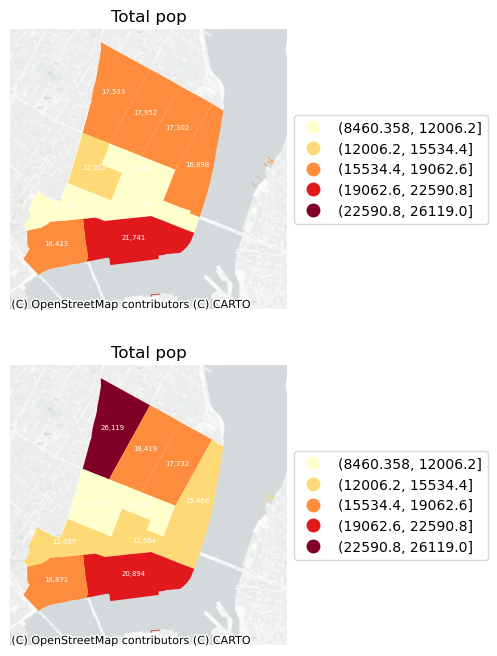

In [138]:
cb3_gdf_sector["coords"] = cb3_gdf_sector["geometry"].centroid.apply(lambda x: x.coords[0])
cb3_gdf_sector['total_cat'], total_labs =  pd.cut(cb3_gdf_sector['total'], 5, retbins=True, include_lowest=True)
#cb3_gdf_sector['total_cat'] = cb3_gdf_sector['total_cat'].astype(str)
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

for j in range(2):
    cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].plot(
        ax=axes[j], column="total_cat", cmap='YlOrRd', categorical=True, legend=True,
        legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"}
    )

    axes[j].set_title(f"Total pop")
    # axes[j].set_axis_off()
    axes[j].set_xticks([])
    axes[j].set_yticks([])
    axes[j].spines["top"].set_visible(False)
    axes[j].spines["right"].set_visible(False)
    axes[j].spines["bottom"].set_visible(False)
    axes[j].spines["left"].set_visible(False)
    
    for idx, row in cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].iterrows():
        axes[j].annotate(
            text=f'{round(row["total"]):,}',
            xy=row["coords"],
            horizontalalignment="center",
            color="white",
            size=5
        )
    cx.add_basemap(axes[j], zoom=17, crs=cb3_gdf_sector.crs, source=cx.providers.CartoDB.Positron)

    # assume it's the first (and only) mappable
    # patch_col = axes[j].collections[0]
    # cb = fig.colorbar(patch_col, ax=axes[j], shrink=0.5)

    # for ax, row in zip(axes[:], [2010, 2020]):
    #     ax.set_ylabel(row, rotation=0, size="large")
plt.savefig("cb3_maps_total.pdf", dpi=300);

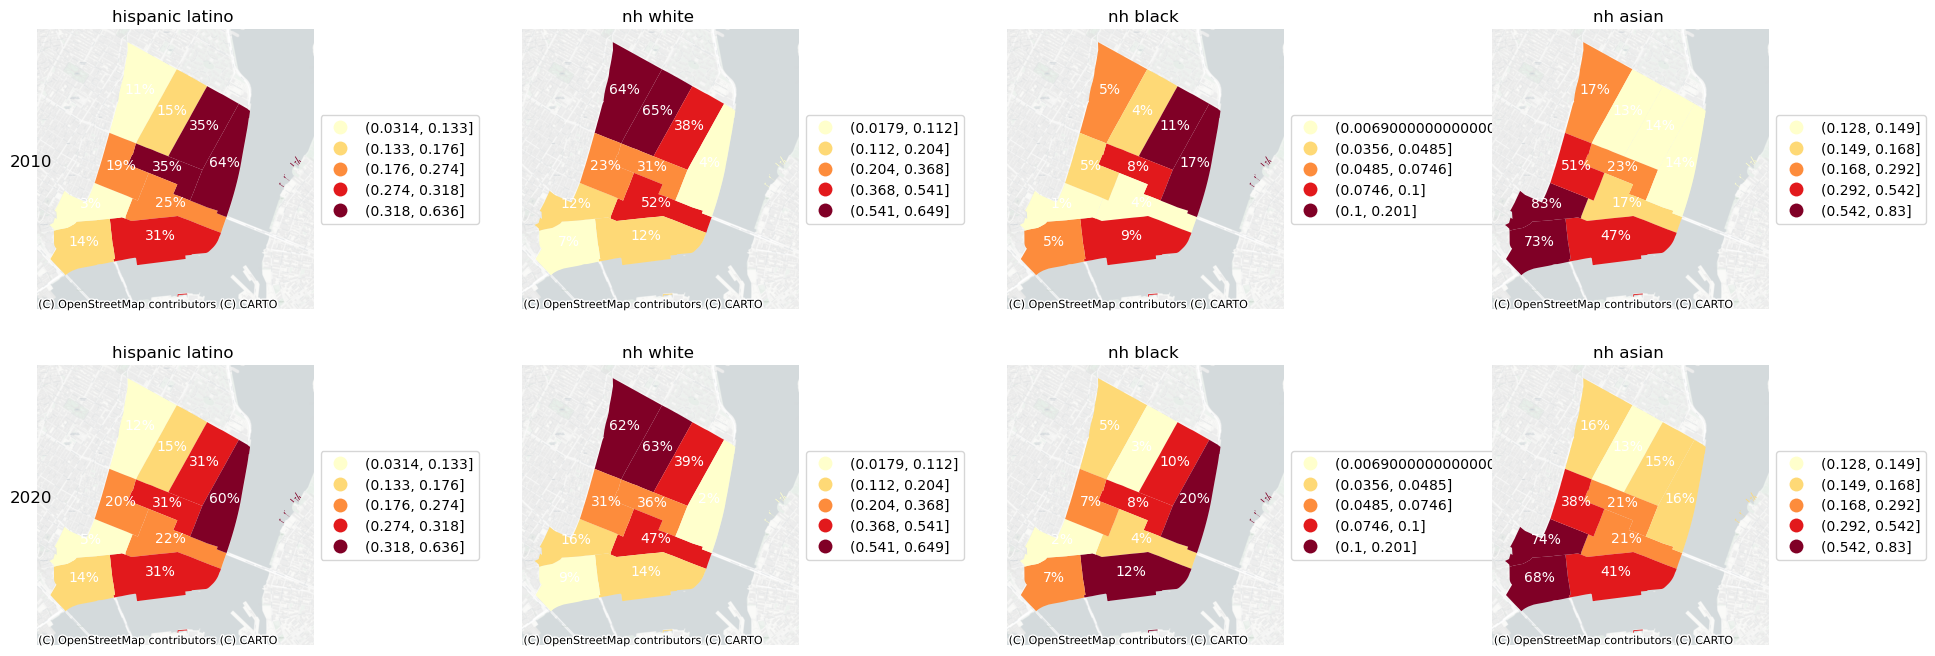

In [153]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))

yrs = [2010, 2020]
for j in range(2):
    for i in range(len(race_cols_per)):
        cb3_gdf_sector[race_cols_per[i] + '_cat'], total_labs =  pd.qcut(cb3_gdf_sector[race_cols_per[i]], 5, 
        retbins=True)
        cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].plot(
            ax=axes[j, i], column=race_cols_per[i] + '_cat', categorical=True, legend=True,
            cmap='YlOrRd',
            legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"}
        )
        axes[j, i].set_title(f"{race_cols_per[i].replace('_', ' ').replace('per','')}")
        # axes[j,i].set_axis_off()
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])
        axes[j, i].spines["top"].set_visible(False)
        axes[j, i].spines["right"].set_visible(False)
        axes[j, i].spines["bottom"].set_visible(False)
        axes[j, i].spines["left"].set_visible(False)
        cx.add_basemap(axes[j,i], zoom=17, crs=cb3_gdf_sector.crs, source=cx.providers.CartoDB.Positron)

        for idx, row in cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].iterrows():
            axes[j, i].annotate(
                text=f'{round(row[race_cols_per[i]]*100)}%',
                xy=row["coords"],
                horizontalalignment="center",
                color="white",
            )
# assume it's the first (and only) mappable
# patch_col = axes[0, 0].collections[0]
# cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

for ax, row in zip(axes[:, 0], [2010, 2020]):
    ax.set_ylabel(row, rotation=0, size="large")
plt.savefig("cb3_maps.pdf", dpi=300);

In [187]:
cb3_gdf_pct_change_long = cb3_gdf_pct_change.melt(id_vars='sectors', value_vars=race_cols)
cb3_gdf_pct_change_long['value_cat'], total_labs = pd.qcut(cb3_gdf_pct_change_long['value'], 5, retbins=True)
cb3_gdf_pct_change_wide = cb3_gdf_pct_change_long.pivot(values=['value', 'value_cat'], columns='variable', index='sectors')

In [ ]:
cb3_gdf_pct_change.to_file('_output_data/cb3_decennial_pctchange.geojson', driver="GeoJSON")

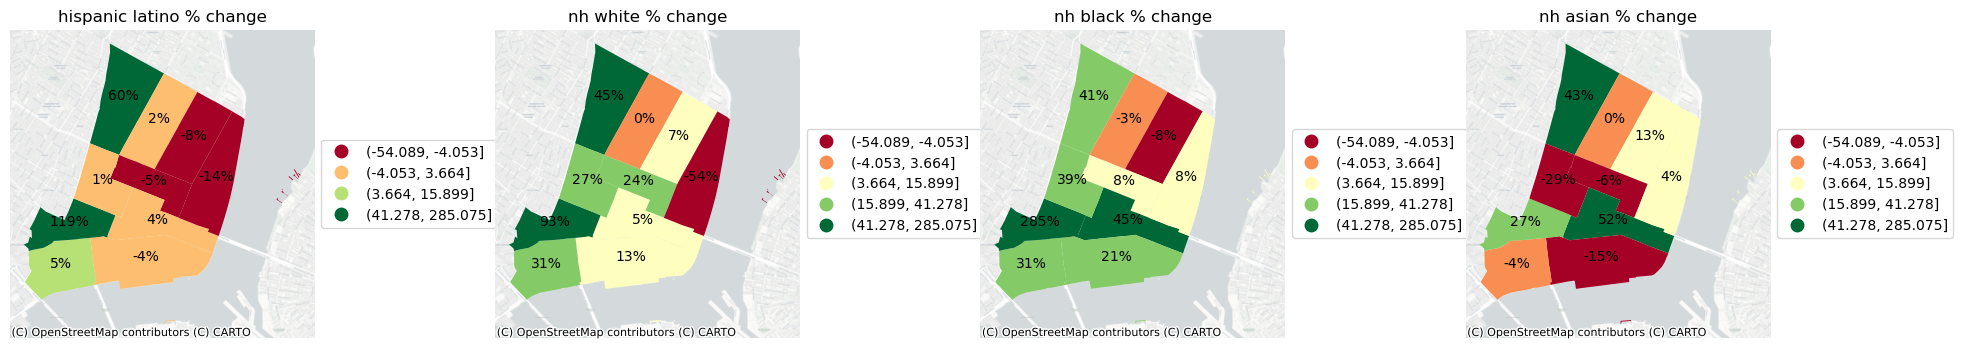

In [191]:
cb3_gdf_diss = cb3_gdf_diss.to_crs(2263)
cb3_gdf_pct_change_cat = cb3_gdf_pct_change[['sectors', 'geometry']].merge(cb3_gdf_pct_change_wide['value_cat'].reset_index(), on='sectors')
cb3_gdf_pct_change_cont = cb3_gdf_pct_change[['sectors', 'geometry']].merge(cb3_gdf_pct_change_wide['value'].reset_index(), on='sectors')

cb3_gdf_pct_change_cont["coords"] = cb3_gdf_pct_change_cont["geometry"].centroid.apply(lambda x: x.coords[0])
fig, axes = plt.subplots(1, 4, figsize=(24, 4))

race_cols = ["hispanic_latino", "nh_white", "nh_black", "nh_asian"]
for i in range(len(race_cols)):
    cb3_gdf_pct_change_cat.plot(
        ax=axes[i], column=race_cols[i], legend=True, categorical=True, cmap="RdYlGn",
        legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"}
    )
    # cb3_gdf_diss.plot(ax=axes[i], facecolor='none')
    for idx, row in cb3_gdf_pct_change_cont.iterrows():
        axes[i].annotate(
            text=f'{round(row[race_cols[i]])}%',
            xy=row["coords"],
            horizontalalignment="center",
            color="black",
        )

    cx.add_basemap(axes[i], zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron)
    axes[i].set_title(f"{race_cols_per[i].replace('_', ' ').replace('per','% change')}")
    axes[i].set_axis_off()
# assume it's the first (and only) mappable
# patch_col = axes[0].collections[0]
# cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)
plt.savefig("cb3_maps_pct_change.pdf");

## ACS Data

In [220]:
# load acs dict
acs_dict = pd.read_excel("acs_dict.xlsx").set_index("colname").to_dict()["textname"]

In [221]:
acs_dict_denom = pd.read_excel("acs_dict.xlsx").set_index("denom_col")
acs_dict_denom = acs_dict_denom[acs_dict_denom.index.notna()]
acs_dict_denom_dict = {
    u: acs_dict_denom.loc[u, "textname"].tolist() for u in acs_dict_denom.index.unique()
}

In [222]:
acs_table = pd.read_excel("acs_dict.xlsx").set_index("table_name")
acs_table = acs_table[acs_table.index.notna()]
acs_table["pct_col"] = np.where(
    acs_table["denom_col"].notna(), acs_table["textname"] + "_pct", ""
)
acs_dict_table = {
    u: acs_table.loc[u, "textname"].tolist() for u in acs_table.index.unique()
}

acs_table_pct = acs_table.loc[acs_table["pct_col"] != ""]
acs_pct_dict_table = {
    u: acs_table_pct.loc[u, "pct_col"].tolist() for u in acs_table_pct.index.unique()
}

In [242]:
acs_gdf = [
    pd.DataFrame(
        census.acs5.get(
            (tuple(["NAME", "GEO_ID"] + list(acs_dict.keys()))),
            geo={
                "for": f"tract:{','.join(cb3_tracts)}",
                "in": f"state:36 county:061",
            },
            year=yr,
        )
    ).assign(year=yr)
    for yr in [2018, 2020, 2023]
]

In [243]:
acs_gdf_clean = pd.concat(acs_gdf).rename(columns=acs_dict)
acs_gdf_clean.head()

,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,total_in_labor_force,total_hh_age,hh_gt65,hh_lt18,total_2person_hh,total_1person_hh,total_hh_size,total_3person_hh,total_4person_hh,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2835.0,1218.0,69.0,111.0,101.0,113.0,30.0,4.0,...,0.0,1071.0,350.0,345.0,410.0,252.0,1071.0,228.0,181.0,2018
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,7764.0,3364.0,65.0,77.0,248.0,99.0,87.0,96.0,...,13.0,3435.0,1139.0,808.0,985.0,1435.0,3435.0,492.0,523.0,2018
2,"Census Tract 6, New York County, New York",1400000US36061000600,9731.0,4588.0,263.0,185.0,129.0,62.0,60.0,0.0,...,250.0,4031.0,1981.0,757.0,1116.0,1695.0,4031.0,702.0,518.0,2018
3,"Census Tract 8, New York County, New York",1400000US36061000800,8993.0,4282.0,86.0,239.0,205.0,120.0,69.0,16.0,...,177.0,3632.0,1661.0,719.0,1305.0,1065.0,3632.0,609.0,653.0,2018
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1455.0,857.0,47.0,17.0,43.0,5.0,5.0,11.0,...,11.0,809.0,325.0,125.0,231.0,443.0,809.0,62.0,73.0,2018


In [244]:
acs_gdf_clean["ct"] = acs_gdf_clean["GEO_ID"].str.slice(-6)
acs_gdf_clean["ct"]

0     000201
1     000202
2     000600
3     000800
4     001001
       ...  
26    003602
27    003800
28    004001
29    004002
30    004200
Name: ct, Length: 90, dtype: object

In [245]:
cb3_acs_gdf = cb3_gdf_concat[cb3_gdf_concat["yr"] == 2020][["ct", "sectors"]].merge(
    acs_gdf_clean, on="ct", how="left"
)
cb3_acs_gdf.head()

,ct,sectors,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,...,total_in_labor_force,total_hh_age,hh_gt65,hh_lt18,total_2person_hh,total_1person_hh,total_hh_size,total_3person_hh,total_4person_hh,year
0,001401,5,"Census Tract 14.01, New York County, New York",1400000US36061001401,3166.0,1286.0,68.0,101.0,74.0,23.0,...,0.0,1595.0,486.0,311.0,577.0,675.0,1595.0,143.0,200.0,2018
1,001401,5,"Census Tract 14.01, New York County, New York",1400000US36061001401,2999.0,1326.0,38.0,106.0,71.0,21.0,...,0.0,1569.0,599.0,281.0,415.0,762.0,1569.0,247.0,145.0,2020
2,001401,5,Census Tract 14.01; New York County; New York,1400000US36061001401,3395.0,1857.0,88.0,96.0,31.0,8.0,...,0.0,1761.0,950.0,215.0,657.0,763.0,1761.0,195.0,146.0,2023
3,001402,5,"Census Tract 14.02, New York County, New York",1400000US36061001402,2748.0,1139.0,22.0,9.0,7.0,9.0,...,0.0,1409.0,501.0,117.0,370.0,753.0,1409.0,182.0,104.0,2018
4,001402,5,"Census Tract 14.02, New York County, New York",1400000US36061001402,2693.0,1309.0,10.0,28.0,29.0,15.0,...,79.0,1476.0,561.0,134.0,400.0,807.0,1476.0,152.0,117.0,2020


In [246]:
cb3_acs_gdf_bysector = cb3_acs_gdf.groupby(["sectors", "year"])[
    list(acs_dict.values())
].sum()
cb3_acs_gdf_total = (
    cb3_acs_gdf.groupby(["year"])[list(acs_dict.values())].sum().reset_index()
)

In [247]:
cb3_acs_gdf_total["sectors"] = "total"
cb3_acs_gdf_total = cb3_acs_gdf_total.set_index(["sectors", "year"])

In [248]:
cb3_acs_gdf_bysector.head()

totalpop  totalpop_male  totalpop_male_u5  totalpop_male_5to9  \
sectors year                                                                  
1       2018   17148.0         8832.0             121.0               144.0   
        2020   26711.0        13113.0             336.0               215.0   
        2023   26021.0        12965.0             358.0               247.0   
2       2018   17147.0         8670.0             146.0               124.0   
        2020   17450.0         8853.0             327.0               101.0   

              totalpop_male_10to14  totalpop_male_15to17  \
sectors year                                               
1       2018                  12.0                  70.0   
        2020                  62.0                 107.0   
        2023                  86.0                 118.0   
2       2018                 152.0                 257.0   
        2020                 204.0                 240.0   

              totalpop_male_18to19  totalpop_male_20  totalpop_male_21  \
sectors year                                                             
1       2018                 748.0             378.0             171.0   
        2020                1514.0             499.0             190.0   
        2023                1471.0             450.0             225.0   
2       2018                   0.0              64.0              61.0   
        2020                  64.0              50.0              99.0   

              totalpop_male_22to24  ...  foreign_born_total  \
sectors year                        ...                       
1       2018                 453.0  ...             17148.0   
        2020                 607.0  ...             26711.0   
        2023                 926.0  ...             26021.0   
2       2018                 439.0  ...             17147.0   
        2020                 345.0  ...             17450.0   

              total_in_labor_force  total_hh_age  hh_gt65  hh_lt18  \
sectors year                                                         
1       2018                  13.0        7787.0   1336.0    304.0   
        2020                  20.0       11826.0   2225.0    644.0   
        2023                  13.0       11639.0   2580.0    788.0   
2       2018                  15.0       10006.0   2110.0    705.0   
        2020                   0.0        9923.0   2337.0    799.0   

              total_2person_hh  total_1person_hh  total_hh_size  \
sectors year                                                      
1       2018            2594.0            4285.0         7787.0   
        2020            3897.0            6434.0        11826.0   
        2023            3585.0            6447.0        11639.0   
2       2018            3067.0            5671.0        10006.0   
        2020            2918.0            5480.0         9923.0   

              total_3person_hh  total_4person_hh  
sectors year                                      
1       2018             495.0             413.0  
        2020             968.0             527.0  
        2023            1276.0             331.0  
2       2018             949.0             319.0  
        2020            1179.0             346.0  

[5 rows x 138 columns]

In [249]:
for col in acs_dict_denom_dict.keys():
    for num in acs_dict_denom_dict[col]:
        cb3_acs_gdf_bysector[num + "_pct"] = (
            cb3_acs_gdf_bysector[num] / cb3_acs_gdf_bysector[col]
        )
        cb3_acs_gdf_total[num + "_pct"] = (
            cb3_acs_gdf_total[num] / cb3_acs_gdf_total[col]
        )

/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_83427/1410431015.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cb3_acs_gdf_bysector[num + "_pct"] = (
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_83427/1410431015.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cb3_acs_gdf_total[num + "_pct"] = (
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_83427/1410431015.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

In [250]:
cb3_acs_gdf_combined = pd.concat(
    [cb3_acs_gdf_bysector, cb3_acs_gdf_total], axis=0
).reset_index()
cb3_acs_gdf_combined.head()

,sectors,year,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,foreign_born_pct,foreign_born_total_pct,total_hh_age_pct,hh_gt65_pct,hh_lt18_pct,total_2person_hh_pct,total_1person_hh_pct,total_hh_size_pct,total_3person_hh_pct,total_4person_hh_pct
0,1,2018,17148.0,8832.0,121.0,144.0,12.0,70.0,748.0,378.0,...,0.234313,1.0,1.0,0.171568,0.039039,0.333119,0.550276,1.0,0.063567,0.053037
1,1,2020,26711.0,13113.0,336.0,215.0,62.0,107.0,1514.0,499.0,...,0.216540,1.0,1.0,0.188145,0.054456,0.329528,0.544055,1.0,0.081854,0.044563
2,1,2023,26021.0,12965.0,358.0,247.0,86.0,118.0,1471.0,450.0,...,0.231198,1.0,1.0,0.221669,0.067703,0.308016,0.553914,1.0,0.109631,0.028439
3,2,2018,17147.0,8670.0,146.0,124.0,152.0,257.0,0.0,64.0,...,0.249140,1.0,1.0,0.210873,0.070458,0.306516,0.566760,1.0,0.094843,0.031881
4,2,2020,17450.0,8853.0,327.0,101.0,204.0,240.0,64.0,50.0,...,0.186590,1.0,1.0,0.235513,0.080520,0.294064,0.552252,1.0,0.118815,0.034868


In [252]:
pct_cols = [x for x in cb3_acs_gdf_bysector.columns if "_pct" in x]
cb3_acs_gdf_long = cb3_acs_gdf_combined.melt(
    id_vars=["sectors", "year"], value_vars=list(acs_dict.values()) + pct_cols
).pivot(columns=["year"], index=["sectors", "variable"], values="value")

cb3_acs_gdf_long["diff"] = cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2020]
cb3_acs_gdf_long["pct_change"] = (
    cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2020]
) / cb3_acs_gdf_long[2020]
cb3_acs_gdf_long = (
    cb3_acs_gdf_long.reset_index()
    .pivot(
        index=["variable"],
        columns=["sectors"],
        values=[2018, 2020, 2023, "diff", "pct_change"],
    )
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, True])
)

In [253]:
# write to excel
workbook = pd.ExcelWriter("acs_summary.xlsx", engine="xlsxwriter")

for col in acs_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_dict_table[col]].reset_index().to_excel(
        workbook, sheet_name=col, index=True
    )

for col in acs_pct_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_pct_dict_table[col]].reset_index().to_excel(
        workbook, sheet_name=col + "_pct", index=True
    )

# workbook.save()
workbook.close()

In [255]:
cb3_gdf_pct_change[['sectors', 'geometry']].merge(cb3_acs_gdf_combined[cb3_acs_gdf_combined['year']==2023], on='sectors')\
    .to_file('_output_data/acs_2023.geojson', driver="GeoJSON")
cb3_gdf_pct_change[['sectors', 'geometry']].merge(cb3_acs_gdf_combined[cb3_acs_gdf_combined['year']==2020], on='sectors')\
    .to_file('_output_data/acs_2020.geojson', driver="GeoJSON")
cb3_gdf_pct_change[['sectors', 'geometry']].merge(cb3_acs_gdf_combined[cb3_acs_gdf_combined['year']==2018], on='sectors')\
    .to_file('_output_data/acs_2018.geojson', driver="GeoJSON")